# Assignment 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np

class GMM:
    def __init__(self, n_components, max_iters=100, tol=1e-6):
        self.n_components = n_components
        self.max_iters = max_iters
        self.tol = tol

    def _multivariate_gaussian(self, X, mean, cov):
        n = X.shape[1]
        cov_inv = np.linalg.inv(cov)
        cov_det = np.linalg.det(cov)
        norm_const = 1.0 / (np.power((2 * np.pi), n / 2) * np.sqrt(cov_det))
        X_centered = X - mean
        result = np.exp(-0.5 * np.sum(X_centered @ cov_inv * X_centered, axis=1))
        return norm_const * result

    def _initialize_params(self, X):
        n_samples, n_features = X.shape
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = np.array([np.cov(X.T) for _ in range(self.n_components)])

    def fit(self, X):
        X = np.asarray(X)
        self._initialize_params(X)
        log_likelihoods = []

        for _ in range(self.max_iters):
            # E-step
            responsibilities = np.zeros((X.shape[0], self.n_components))
            for j in range(self.n_components):
                responsibilities[:, j] = self.weights[j] * self._multivariate_gaussian(
                    X, self.means[j], self.covariances[j]
                )
            responsibilities /= responsibilities.sum(axis=1, keepdims=True)

            # M-step
            Nk = responsibilities.sum(axis=0)
            self.weights = Nk / X.shape[0]
            self.means = (responsibilities.T @ X) / Nk[:, np.newaxis]
            for j in range(self.n_components):
                X_centered = X - self.means[j]
                self.covariances[j] = (
                    responsibilities[:, j][:, np.newaxis] * X_centered
                ).T @ X_centered / Nk[j]

        return self

    def predict(self, X):
        probs = np.array([
            self.weights[j] * self._multivariate_gaussian(X, self.means[j], self.covariances[j])
            for j in range(self.n_components)
        ])
        return np.argmax(probs, axis=0)


In [3]:
np.random.seed(10)
u1 = np.random.multivariate_normal([2, 2], np.eye(2), size = 100)
u2 = np.random.multivariate_normal([8, 3], np.eye(2), size = 100)
u3 = np.random.multivariate_normal([3, 6], np.eye(2), size = 100)
X = np.concatenate((u1, u2, u3), axis=0)

In [4]:
model = GMM(n_components=3)
model.fit(X)
labels = model.predict(X)

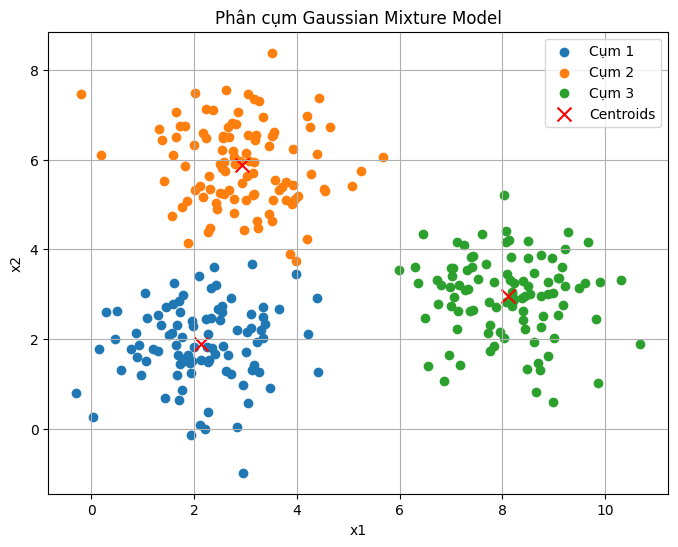

In [5]:
# Trực quan hóa kết quả
plt.figure(figsize=(8,6))
for i in range(3):
    cluster = X[labels == i]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cụm {i+1}')
centroids = model.means
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', color = 'red', s=100, label = 'Centroids')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Phân cụm Gaussian Mixture Model')
plt.legend()
plt.grid(True)
plt.show()

# Assignment 2

In [6]:
from PIL import Image
# Đọc và chuyển ảnh sang dạng RGB
img = Image.open('cow.jpg')
img = img.convert('RGB')
img_array = np.array(img)
H, W, C = img_array.shape # lấy kích thước ảnh
X_rgb = img_array.reshape(-1, 3)/255 # Chuẩn hóa màu ảnh
x_coords, y_coords = np.meshgrid(np.arange(W), np.arange(H))
X_pos = np.stack((x_coords, y_coords), axis=-1).reshape(-1, 2) / max(H, W) # Chuan hoa toa do
X = np.concatenate([X_rgb, X_pos], axis=1)

In [7]:
gmm = GMM(n_components=2, max_iters=30)
gmm.fit(X)
labels = gmm.predict(X)

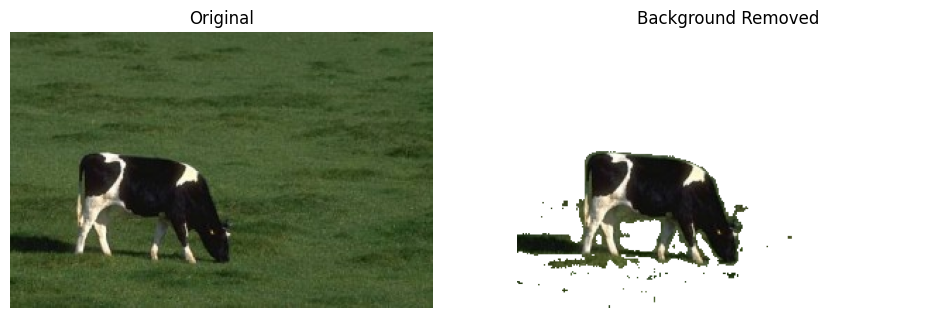

In [8]:
# Cụm lớn nhất là nền
(unique, counts) = np.unique(labels, return_counts = True)
bg_label = unique[np.argmax(counts)]
# Ảnh mới không có nền
foreground = img_array.copy().reshape(-1, 3)
foreground[labels == bg_label] = [255, 255, 255]
# Hiển thị
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(img_array)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Background Removed')
plt.imshow(foreground.reshape(H, W, 3))
plt.axis('off')
plt.show()

So sánh với Gaussian Mixture từ thư viện scikit learn

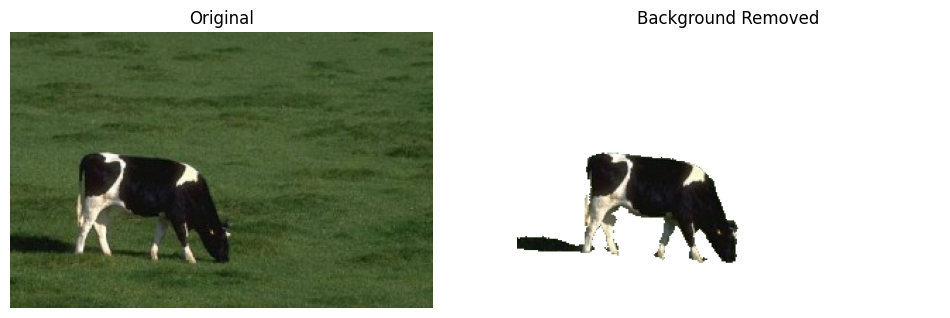

In [9]:
from sklearn.mixture import GaussianMixture

img = Image.open('cow.jpg')
img_np = np.array(img)
H, W, C = img_np.shape
X = img_np.reshape(-1, 3)
n_components = 3
gmm = GaussianMixture(n_components=3, covariance_type='tied', random_state=0)
gmm.fit(X)
labels = gmm.predict(X)

# Cụm lớn nhất là nền
(unique, counts) = np.unique(labels, return_counts = True)
bg_label = unique[np.argmax(counts)]
# Ảnh mới không có nền
foreground = img_array.copy().reshape(-1, 3)
foreground[labels == bg_label] = [255, 255, 255]
# Hiển thị
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(img_array)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Background Removed')
plt.imshow(foreground.reshape(H, W, 3))
plt.axis('off')
plt.show()


-> GMM từ scikit learn lọc được nền kĩ hơn

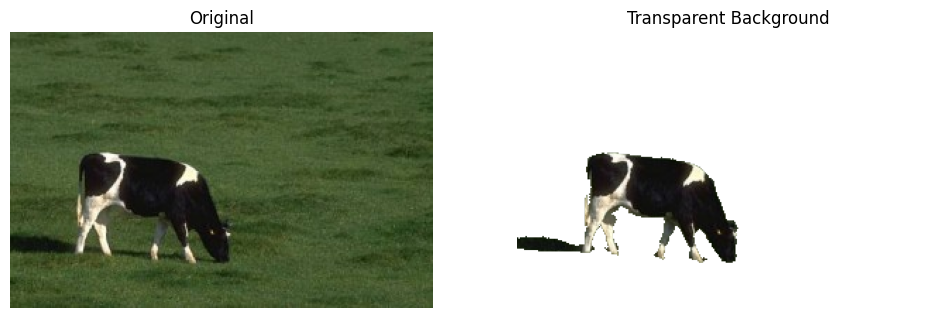

In [10]:
# Chuyển thành ảnh nền trong suốt
(unique, counts) = np.unique(labels, return_counts=True)
bg_label = unique[np.argmax(counts)]
# Chuyển ảnh sang RGBA
rgba_img = np.dstack((img_array, np.ones((H, W), dtype=np.uint8) * 255))  # kênh alpha = 255 (không trong suốt)
rgba_img = rgba_img.reshape(-1, 4)

# nền trong suốt (alpha = 0)
rgba_img[labels == bg_label, 3] = 0
# chuyển về ảnh
transparent_img = rgba_img.reshape(H, W, 4)

# hiển thị
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(img_array)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Transparent Background')
plt.imshow(transparent_img)
plt.axis('off')
plt.show()